# Nenana Ice Classic Modeling
This notebook was used for modeling the NIC data.

In [1]:
# imports

import numpy as np
import pandas as pd

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
sns.set_style('whitegrid', {'axes.grid' : False}) # turn off gridlines

# pipeline and preprocessing
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder

# models
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import TransformerMixin

# evaluation
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn import metrics # accuracy_score

# filter warnings
import warnings
warnings.filterwarnings("ignore")

import gc # garbage collection

## Helper Function

In [2]:
class ForestEncoder(TransformerMixin):
    
    def __init__(self, forest):
        self.forest = forest
        self.n_trees = 1
        try:
            self.n_trees = self.forest.n_estimators
        except:
            pass
        self.ohe = OneHotEncoder(cols=range(self.n_trees), use_cat_names=True)
        
    def fit(self, X, y=None):
        self.forest.fit(X, y)
        self.ohe.fit(self.forest.apply(X))
        return self
    
    def transform(self, X, y=None):
        return self.ohe.transform(self.forest.apply(X))


#### Read data from files

In [3]:
training_df = pd.read_csv('../data/model_training_data.csv')

In [4]:
training_df.head()

,Date,moonPhase,humidity,windSpeed,windBearing,uvIndex,precipIntensity,winningTime,daylightHours,iceThickness,...,numColdDays_MA-accel5,numColdDays_MA-std_dev5,numColdDays_MA7,numColdDays_MA-slope7,numColdDays_MA-accel7,numColdDays_MA-std_dev7,numColdDays_MA10,numColdDays_MA-slope10,numColdDays_MA-accel10,numColdDays_MA-std_dev10
0,1989-03-10,0.14,0.31,9.60,78.0,1.0,0.0,0,0.465278,37.5,...,-7.142857e-01,1.303840e+00,4.857143,0.892857,-0.297619,1.951800,3.5,0.890909,-4.143851e-16,2.718251
1,1989-03-11,0.17,0.36,9.35,71.0,0.0,0.0,0,0.470139,37.5,...,-1.071429e+00,8.944272e-01,5.571429,0.714286,-0.595238,1.618347,4.2,0.848485,-2.651515e-01,2.616189
2,1989-03-12,0.21,0.41,6.70,59.0,1.0,0.0,0,0.475000,37.5,...,-7.142857e-01,4.472136e-01,6.142857,0.500000,-0.714286,1.214986,4.9,0.721212,-3.977273e-01,2.282786
3,1989-03-13,0.24,0.43,2.53,109.0,1.0,0.0,0,0.479167,37.5,...,3.332111e-15,2.471078e-08,6.571429,0.285714,-0.595238,0.786796,5.5,0.575758,-4.734848e-01,1.900292
4,1989-03-14,0.28,0.57,2.16,295.0,1.0,0.0,0,0.484028,37.5,...,3.332111e-15,2.471078e-08,6.857143,0.107143,-0.297619,0.377964,6.0,0.424242,-4.734848e-01,1.490712


In [5]:
testing_df = pd.read_csv('../data/model_testing_data.csv')

In [6]:
testing_df.head()

,Date,moonPhase,humidity,windSpeed,windBearing,uvIndex,precipIntensity,winningTime,daylightHours,iceThickness,...,numColdDays_MA-accel5,numColdDays_MA-std_dev5,numColdDays_MA7,numColdDays_MA-slope7,numColdDays_MA-accel7,numColdDays_MA-std_dev7,numColdDays_MA10,numColdDays_MA-slope10,numColdDays_MA-accel10,numColdDays_MA-std_dev10
0,2015-03-10,0.67,0.62,0.79,136.0,1.0,0.0,0,0.463889,38.5,...,7.142857e-01,1.303840,1.857143,0.500000,7.142857e-01,1.214986,1.6,0.278788,0.397727,1.074968
1,2015-03-11,0.70,0.61,0.77,317.0,1.0,0.0,0,0.468750,38.5,...,5.880195e-16,1.581139,2.428571,0.714286,5.952381e-01,1.618347,2.0,0.424242,0.473485,1.490712
2,2015-03-12,0.73,0.61,1.45,307.0,1.0,0.0,0,0.472917,38.5,...,1.176039e-15,1.581139,3.142857,0.892857,2.976190e-01,1.951800,2.5,0.575758,0.473485,1.900292
3,2015-03-13,0.77,0.57,1.36,257.0,1.0,0.0,0,0.477778,38.5,...,1.764059e-15,1.581139,4.000000,1.000000,-3.853551e-16,2.160247,3.1,0.721212,0.397727,2.282786
4,2015-03-14,0.80,0.60,0.66,128.0,1.0,0.0,0,0.482639,38.5,...,5.880195e-16,1.581139,5.000000,1.000000,7.707102e-17,2.160247,3.8,0.848485,0.265152,2.616189


In [7]:
# columns to exclude from models (dates and target info)
exclude = ['winningTime', 'winningDate',  'Date']

In [8]:
used_cols = [c for c in training_df.columns if c not in exclude]

In [9]:
training_df.dropna(inplace = True)

In [10]:
testing_df.dropna(inplace = True)

In [11]:
gc.collect()

11

## Modeling

#### Random Guess Accuracy = 0.9827072152653548

In [12]:
target = 'winningDate'

#### Best Performing Model
Scoring for this model became 'NaN' after I began using TimeSeriesSplit(), but that was necessary because the data is time-series data.

To guage actual performance, I used confusion matrices.

In [13]:
rf = RandomForestClassifier(bootstrap = True,
                            class_weight = 'balanced',
                            criterion = 'entropy',
                            max_depth = 6,
                            max_features = 'sqrt',
                            min_samples_leaf = 1,
                            min_samples_split = 2,
                            n_estimators = 60,
                            n_jobs = -1, random_state = 42)

encoder = ForestEncoder(rf)

clf = LogisticRegressionCV(class_weight = 'balanced',
                           random_state = 42,
                           cv = TimeSeriesSplit(),
                           solver = 'liblinear',
                           n_jobs = -1,
                           scoring = 'recall')

pipe = make_pipeline(encoder, clf)

X_train, y_train = training_df[used_cols], training_df[target]

scores = cross_validate(pipe, X_train, y_train, cv = TimeSeriesSplit(),
                        scoring=['f1_weighted', 'precision_weighted', 'recall_weighted', 'accuracy',
                                 'roc_auc'])

print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(), '+/-',
      scores['test_precision_weighted'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-',
      scores['test_recall_weighted'].std())
print('accuracy:', scores['test_accuracy'].mean(), '+/-',
      scores['test_accuracy'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

f1_weighted: nan +/- nan
precision_weighted: nan +/- nan
recall_weighted: nan +/- nan
accuracy: nan +/- nan
roc_auc: nan +/- nan


In [14]:
pipe.fit(X_train, y_train)
X_test = testing_df[used_cols]
y_test = testing_df[target]
y_pred = pipe.predict(X_test)
y_pred_train = pipe.predict(X_train)

#### Check model accuracy

In [15]:
print('Training set accuracy:', metrics.accuracy_score(y_train, y_pred_train))
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))

Training set accuracy: 0.9349112426035503
Test set accuracy: 0.9570815450643777


In [16]:
metrics.confusion_matrix(y_test, y_pred)

array([[219,   9],
       [  1,   4]])

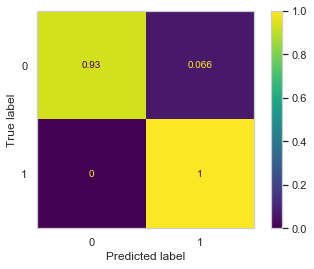

In [17]:
metrics.plot_confusion_matrix(pipe, X_train, y_train, normalize = 'true');

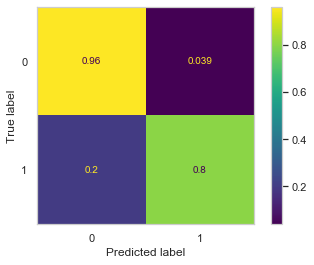

In [18]:
metrics.plot_confusion_matrix(pipe, X_test, y_test, normalize = 'true');

In [19]:
y_pred_prob = rf.predict_proba(X_test)[:,1]
y_pred_prob[:5]

array([0., 0., 0., 0., 0.])

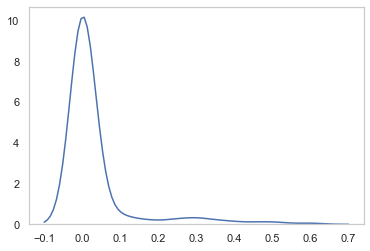

In [20]:
sns.kdeplot(y_pred_prob);

In [21]:
metrics.confusion_matrix(y_test, y_pred_prob > 0.03)

array([[192,  36],
       [  0,   5]])

#### Plot predicted probabilities vs actual values in testing data

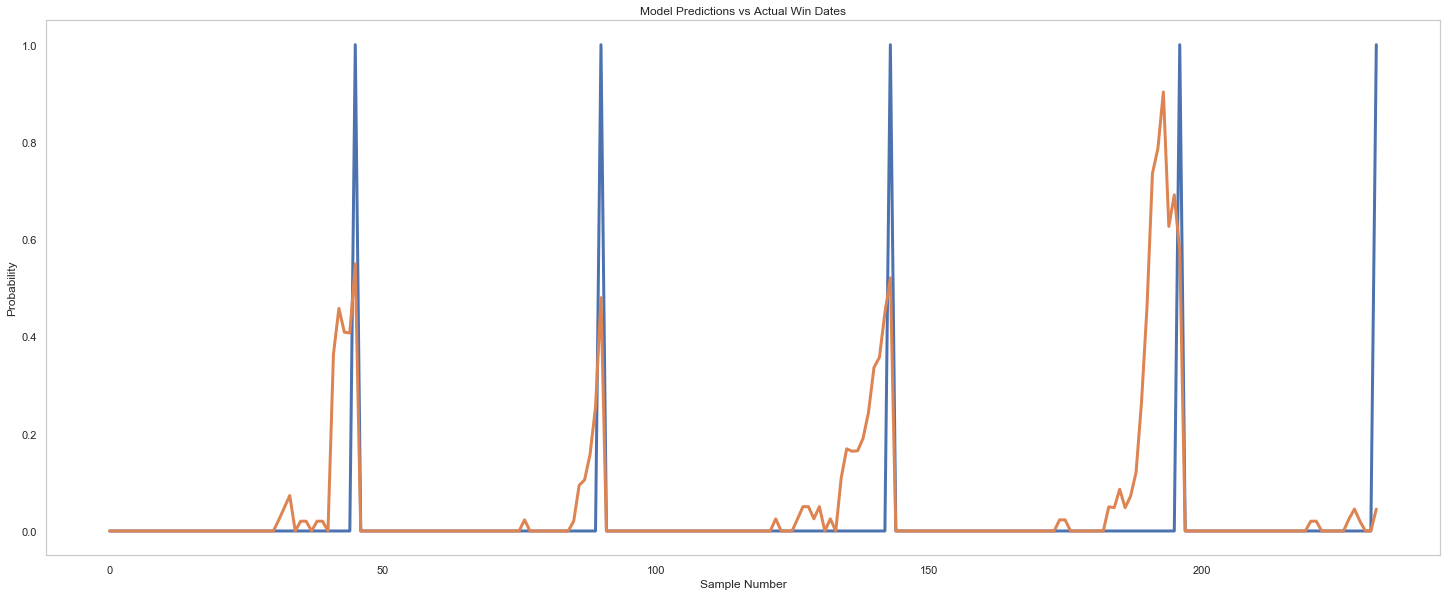

In [22]:
plt.figure(figsize=(20,8))
sns.lineplot(x = testing_df.index, y = y_test.values, palette = 'tab10', linewidth = 3) # plot true values
sns.lineplot(x = testing_df.index, y = 1.5*y_pred_prob, palette = 'tab10', linewidth = 3) # plot predictions

plt.tight_layout()
plt.title('Model Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show();